In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, MLSolver

Precompiling packages...
  28982.8 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 33 seconds. 474 already precompiled.


In [2]:
using CairoMakie, ProgressLogging

## Basic no space solve

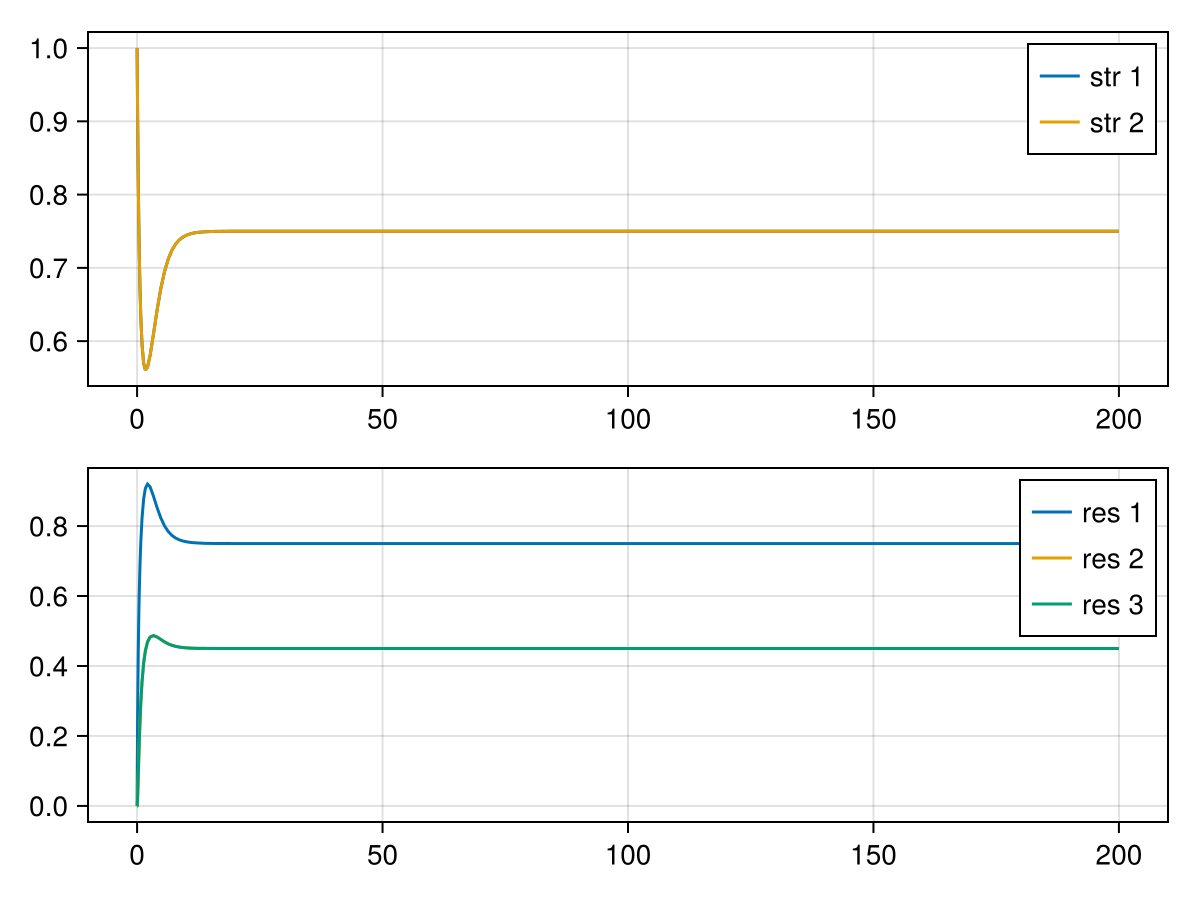

CairoMakie.Screen{IMAGE}


In [3]:
D = fill(0., 2, 3, 3)
D[1,:,:] .= [0. 0. 0.; 0. 0. 0.; 1 0. 0.]
D[2,:,:] .= [0. 0. 0.; 1. 0. 0.; 0. 0. 0.]
p = make_mmicrm_smart(2, 3, 200;
    D=SArray{Tuple{2,3,3}}(D),
    K=[3., 0., 0.],
    r=[1., 1., 1.],
    l=[1. 0. 0.; 1. 0. 0.],
    c=[2. 2. 0.; 2. 0. 2.],
    m=[0.9, 0.9],
    u0=[1., 1., 0., 0., 0.],
    u0rand=0.
)
s = solve(p)
display(plot_mmicrm_sol(s))
# display(p.p.c)
# display(p.p.D[1,:,:])
# display(p.p.D[2,:,:])
#show(s.u[end])
# param_summary(p.p)

## Linear stability analysis

In [4]:
symsol = symbolic_solve_ode_ml(p)

┌ Warning: Solve::ratnz: Solve was unable to solve the system with inexact coefficients.
│     The answer was obtained by solving a corresponding exact system and
│     numericizing the result.
└ @ MathLink ~/.julia/packages/MathLink/S39uA/src/eval.jl:16


3-element Vector{Vector{Pair{Symbolics.Num, Symbolics.Num}}}:
 [u1 => 0.75, u2 => 0.75, u3 => 0.75, u4 => 0.45, u5 => 0.45]
 [u1 => 0.16666666666666666, u2 => 0.16666666666666666, u3 => 1.8, u4 => 0.45, u5 => 0.45]
 [u1 => 0.0, u2 => 0.0, u3 => 3.0, u4 => 0.0, u5 => 0.0]

In [5]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[0.7499991588608942, 0.7499991588608942, 0.7500007386390256, 0.4500002918297526, 0.4500002918297526]

In [6]:
ks = LinRange(0., 10., 10000)
Ds = [0.01, 0.01, 1e2, 1., 1.]
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(sssol.u, p.p, 0))

[4.3774413793952167e-7, 4.3774413793952167e-7, -4.311362995501611e-7, -1.2630005818969892e-7, -1.2630005818969892e-7]

maximum(real(lambdas)) = 0.23503411881277064


[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.427410
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.427410


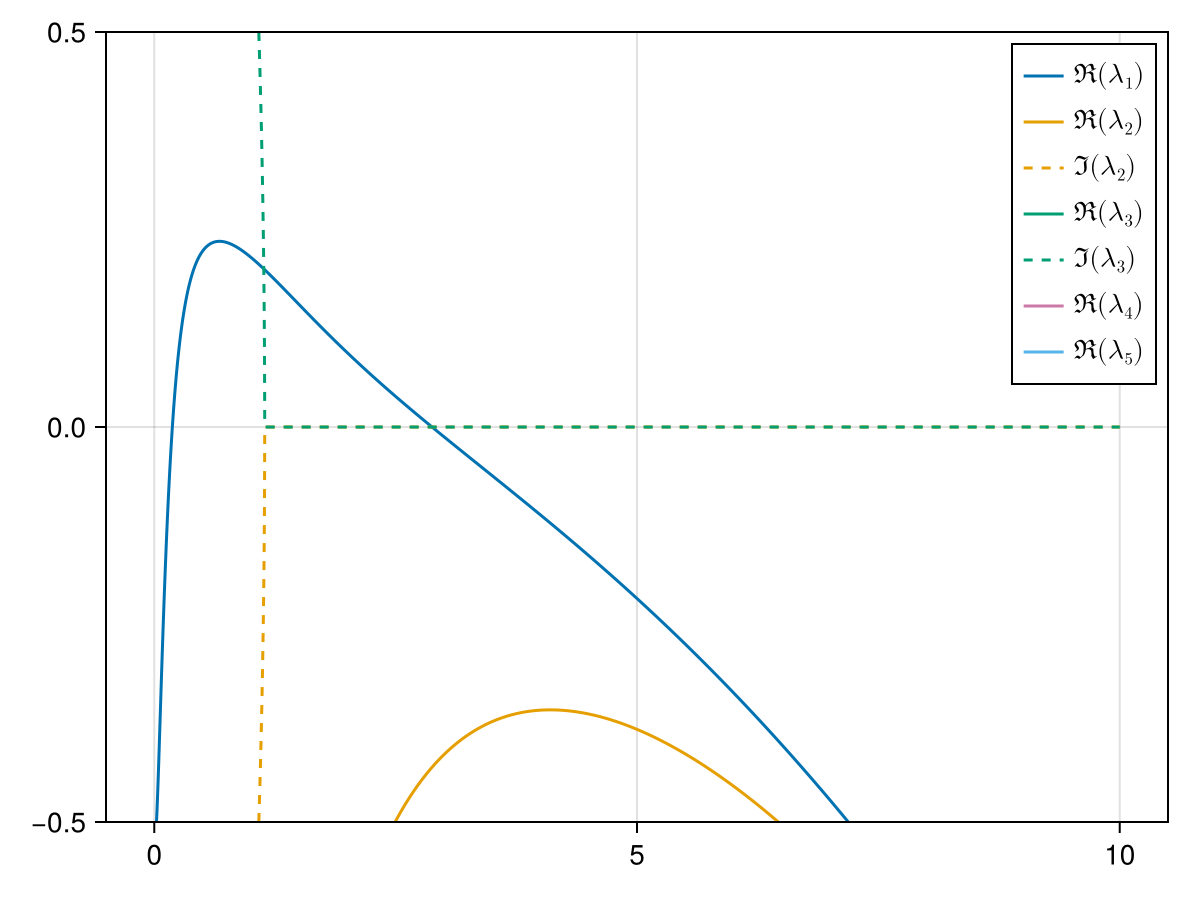

In [7]:
lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.5, 0.5))
#xlims!(faa.axis, (0., 2.))
faa

In [8]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(676, 0.6750675067506751)

In [9]:
kmax_es = ff(kmax);
kmax_es.vectors[:,1]

5-element Vector{ComplexF64}:
   0.6976388793421477 + 0.0im
   0.6976388793421481 + 0.0im
 -0.04202082925366469 + 0.0im
   0.1114321272553347 + 0.0im
  0.11143212725533479 + 0.0im

## Spatial stuff - 1D!

In [10]:
using SSMCMain.SpaceMMiCRM

In [11]:
ssize = (200,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)

5×200 Matrix{Float64}:
 0.754942  0.825641  0.770253  0.815769  …  0.83468   0.808201  0.778732
 0.767902  0.767106  0.829507  0.803832     0.832264  0.753884  0.820004
 0.800769  0.791586  0.829255  0.789567     0.783033  0.83569   0.785928
 0.521151  0.473735  0.472731  0.460769     0.50106   0.485879  0.487953
 0.505208  0.510679  0.45251   0.503595     0.465321  0.531164  0.494503

In [56]:
space = make_cartesianspace_smart(length(ssize); dx=0.1)
sp = make_smmicrm_problem_safe(psu0, 1000000, p.p, SA[Ds...], space, 18)

ODEProblem with uType Matrix{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 1.0e6)
u0: 5×200 Matrix{Float64}:
 0.754942  0.825641  0.770253  0.815769  …  0.83468   0.808201  0.778732
 0.767902  0.767106  0.829507  0.803832     0.832264  0.753884  0.820004
 0.800769  0.791586  0.829255  0.789567     0.783033  0.83569   0.785928
 0.521151  0.473735  0.472731  0.460769     0.50106   0.485879  0.487953
 0.505208  0.510679  0.45251   0.503595     0.465321  0.531164  0.494503

  3.941115 seconds (2.29 M allocations: 544.763 MiB, 3.31% gc time)


ReturnCode.Success = 1

10542

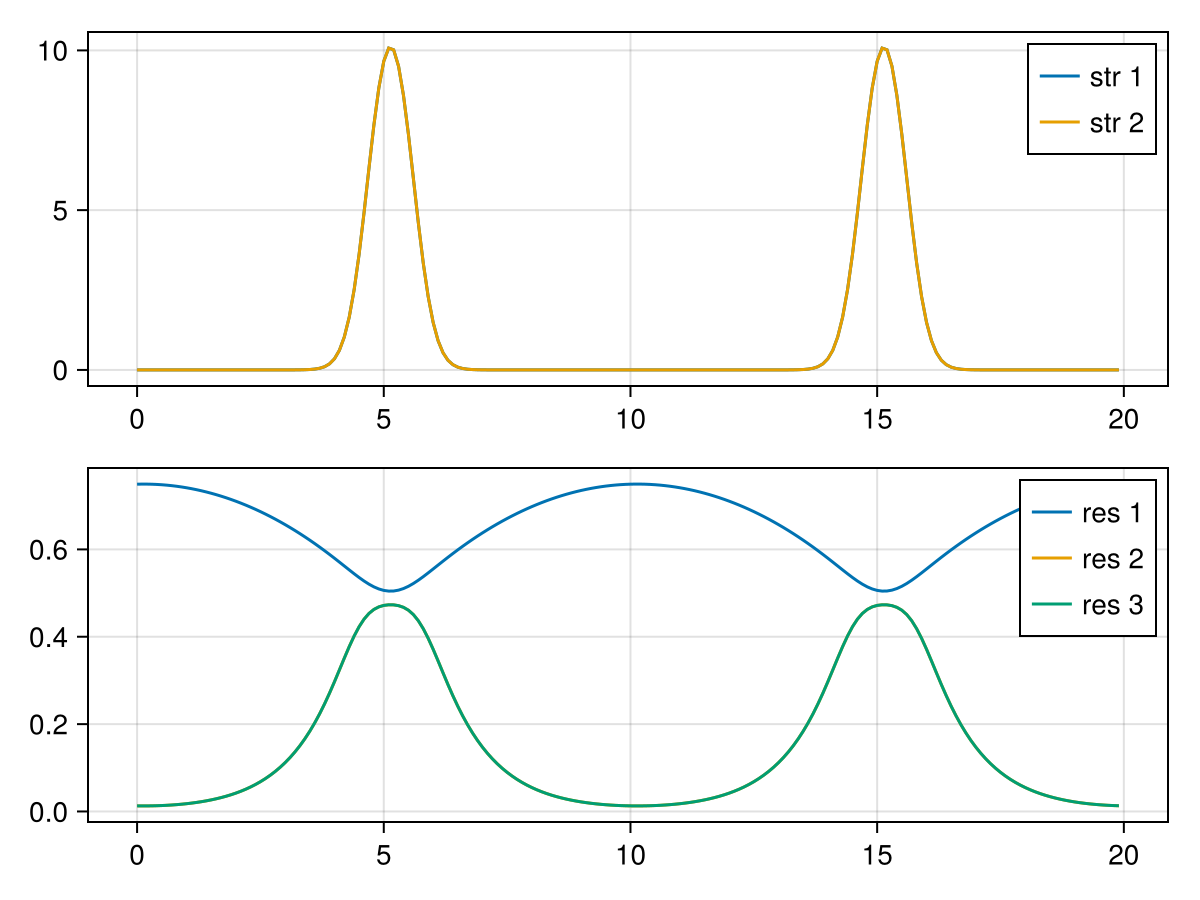

In [57]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

  8.427339 seconds (16.65 M allocations: 1.910 GiB, 4.48% gc time, 168.78% compilation time)


ReturnCode.Success = 1

11673

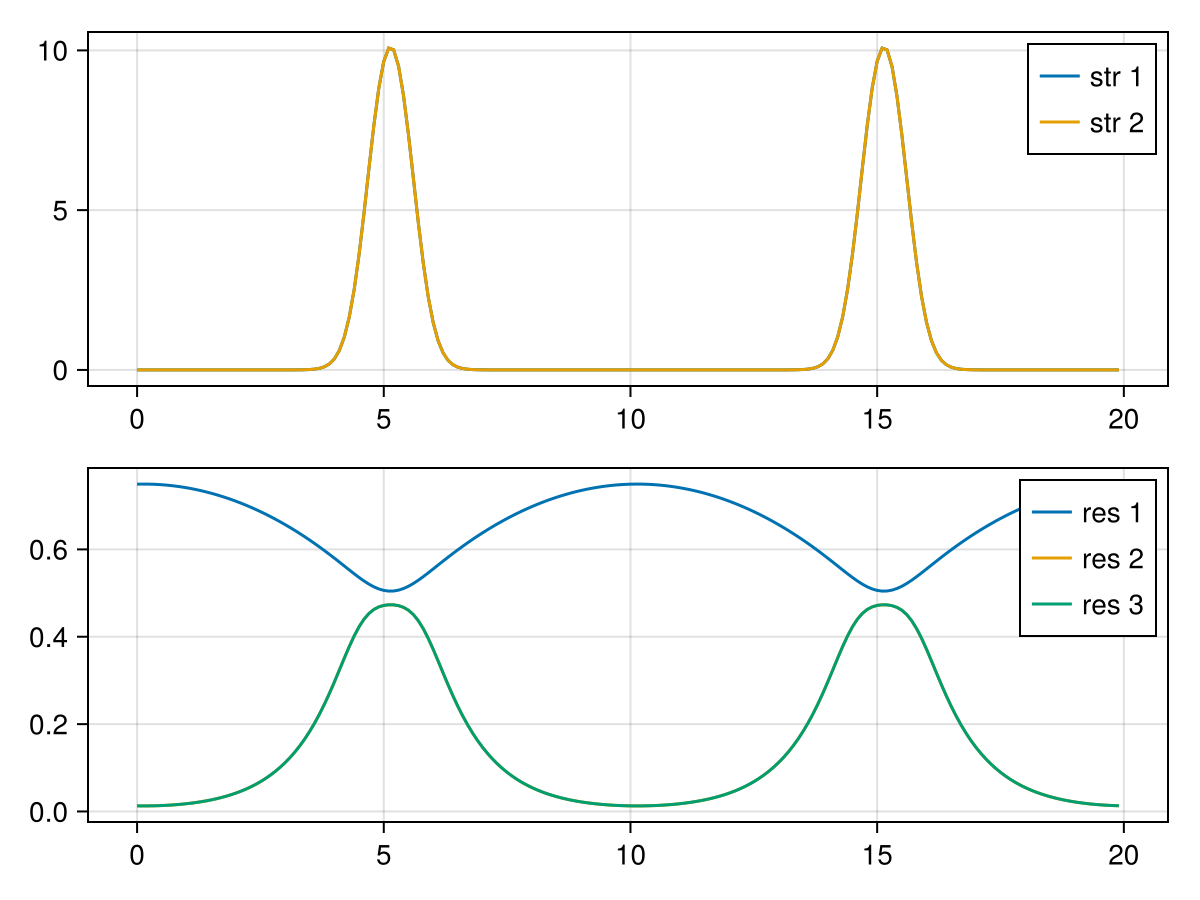

In [47]:
@time sps = solve(sp, QNDF())
display(sps.retcode)
display(sps.destats.nf)
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

In [32]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  8636
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    51
Number of linear solves:                           475
Number of Jacobians created:                       8
Number of nonlinear solver iterations:             405
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          158
Number of rejected steps:                          3

#### Benchmarking the smmicrmfunc!

In [161]:
using Base.Threads
using BenchmarkTools

In [162]:
ssize = (100,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.2, 0.2)
space = make_cartesianspace_smart(length(ssize); dx=0.1)
sp = make_smmicrm_problem_safe(psu0, 10000, p.p, SA[Ds...], space);
@show sp.p.usenthreads
@show typeof(sp.u0)
size(sp.u0)

sp.p.usenthreads = nothing
typeof(sp.u0) = SizedMatrix{5, 100, Float64, 2, Matrix{Float64}}


(5, 100)

In [163]:
tsp = sp;
#tsp = change_usenthreads(sp, nthreads());

In [164]:
du = similar(tsp.u0)
du .= 0
@time tsp.f(du, tsp.u0, tsp.p)
@benchmark tsp.f(du, tsp.u0, tsp.p)

  0.000067 seconds (404 allocations: 37.938 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  20.048 μs …  27.284 ms  ┊ GC (min … max):  0.00% … 99.56%
 Time  (median):     41.535 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   43.156 μs ± 382.599 μs  ┊ GC (mean ± σ):  12.49% ±  1.41%

      ▃▅█▃                     ▁▄▅▅▇▇▄▃▂                        
  ▂▃▇█████▇▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▄███████████▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁ ▃
  20 μs           Histogram: frequency by time         60.6 μs <

 Memory estimate: 37.94 KiB, allocs estimate: 404.

In [165]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()